# Глубинное обучение для текстовых данных, ФКН ВШЭ

## Домашнее задание 4: Direct Preference Optimization 

__Мягкий дедлайн 16.11.25 23:59__ \
__Жесткий дедлайн 19.11.25 23:59__

### О задании

В этом задании вам предстоит обучить большую LLM для ответов на вопросы с помощью DPO, а также реализовать LoRA для эффективного обучения.

### Оценивание и штрафы

Максимально допустимая оценка за работу — __11 баллов__.

Оценка за это домашнее задание будет формироваться из оценки за __задания__ и за __отчет__, в котором от вас требуется написать о проделанной работе. За отчет можно получить до 2-х баллов, однако в случае отсутствия отчета баллы за соответствующие задания не будут ставиться. Мы настаиваем на том, чтобы вы оформили весь код в виде полноценного проекта. Этот ноутбук нужно рассматривать скорее как файл с условием, чем как место для написания массивного кода. За сдачу больших ноутбуков с кодом оценка будет снижена. Ответы на все вопросы в заданиях можно (нужно) писать в отчете.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

### План решения

<!-- <img src="https://miro.medium.com/v2/resize:fit:1400/1*lK6iJMz5CGh2fo7TsDn15A.png" alt="drawing" width="700"/> -->

Обучение следованию инструкциям с помощью DPO разбивается на два этапа:    
1. __Supervised Fine-tuning (SFT)__ – обучение базовой модели ответам на запросы в нужном формате.
2. __Direct Preference Optimization (DPO)__ – обучение SFT модели приоритизации "хороших" ответов.

Мы не хотим обучать модели целиком по двум причинам: 1) используемые модели очень большие; 2) нам требуется лишь выравнить модель с нашими предпочтениями, не внося в нее новых знаний, что не требует серьезного обучения. Поэтому мы будем использовать PEFT, а именно LoRA для обучения.

Таким образом, вам надо будет:
1. Реализовать и протестировать LoRA
2. Разобраться с данными и привести их к нужному формату
3. Обучить SFT модель
4. Обучить DPO модель
5. Порадоваться, что вы молодцы и со всем справились
6. (Опционально) сделать веб-интерфейс для вашей модели, переиспользуя код из первой домашки (мы можем выдать бонусы, если получится классно).

In [1]:
%load_ext autoreload
%autoreload 2

### О датасете

Мы будем работать с датасетом [Anthropic Helpful-Harmless](https://huggingface.co/datasets/Anthropic/hh-rlhf) для RLHF. В нем содержится 160к примеров ответов на вопросы с историей.

In [2]:
from datasets import load_dataset
dataset = load_dataset('Anthropic/hh-rlhf')

### Low-Rank Adaptation (LoRA)

<img src="https://heidloff.net/assets/img/2023/08/lora.png" alt="drawing" width="600"/>

__Задание 1 (3 балла).__ Реализуйте самостоятельно модуль LoRA для эффективного обучения LLM по схеме, описанной в [статье](https://arxiv.org/pdf/2106.09685). Встройте его в свою любимую LLM и убедитесь, что ошибка убывает при обучении параметров LoRA на безусловную генерацию. Для этого возьмите любые данные на свой выбор. Замерьте насколько уменьшилось число обучаемых параметров, как изменилась скорость во время forward и backward процессов и как изменились затраты по памяти. Сделайте выводы и напишите о них в отчете.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL = 'EleutherAI/pythia-1.4b'

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

Embedding(50278, 2048)

In [5]:
inputs = tokenizer("what up big g", return_tensors="pt")

tokens = model.generate(**inputs)
print(tokenizer.decode(tokens[0]))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/home/user/Desktop/SSL/ssl-env/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


what up big geezers?" "I'm not a big guy." "I'm a


In [6]:
def n_params(model):
    return sum([p.numel() for p in model.parameters()])

def train_params(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

n_params(model)

1414541312

In [7]:
print(f'{"total params:":<20} {n_params(model):,}')
print(f'{"trainable params:":<20} {train_params(model):,}')

total params:        1,414,541,312
trainable params:    1,414,541,312


In [9]:
from torch import nn
from src.lora import LoRALayer

RANK = 32

for param in model.parameters():
    param.requires_grad = False

modules_to_replace = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and (name.endswith('dense') or name.endswith('query_key_value')):
        modules_to_replace.append(name)

for name in modules_to_replace:
    parent_name = ".".join(name.split('.')[:-1])
    child_name = name.split('.')[-1]
    parent_module = model.get_submodule(parent_name)
    target_module = getattr(parent_module, child_name)

    lora_layer = LoRALayer(target_module, RANK)
    setattr(parent_module, child_name, lora_layer)
    print(f"Replaced {name} with LoRALayer")

Replaced gpt_neox.layers.0.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.0.attention.dense with LoRALayer
Replaced gpt_neox.layers.1.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.1.attention.dense with LoRALayer
Replaced gpt_neox.layers.2.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.2.attention.dense with LoRALayer
Replaced gpt_neox.layers.3.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.3.attention.dense with LoRALayer
Replaced gpt_neox.layers.4.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.4.attention.dense with LoRALayer
Replaced gpt_neox.layers.5.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.5.attention.dense with LoRALayer
Replaced gpt_neox.layers.6.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.6.attention.dense with LoRALayer
Replaced gpt_neox.layers.7.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.7.attention.dense with Lo

In [10]:
print(f'{"total params:":<20} {n_params(model):,}')
print(f'{"trainable params:":<20} {train_params(model):,}')

total params:        1,423,978,496
trainable params:    9,437,184


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 160800
    })
    test: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 8552
    })
})

In [90]:
NUM_PROC = 8
def tokenize_function(examples):
    return tokenizer(examples['chosen'], padding="max_length", truncation=False)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=dataset["train"].column_names, num_proc=NUM_PROC)

Map (num_proc=8):   0%|          | 0/160800 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the

Map (num_proc=8):   0%|          | 0/8552 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to pad to max_length but no maximum length is provided and the

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Descriptive statistics for sequence lengths:
count    8552.000000
mean      229.937675
std       186.270671
min        15.000000
25%       102.000000
50%       184.000000
75%       302.000000
max      2017.000000
dtype: float64


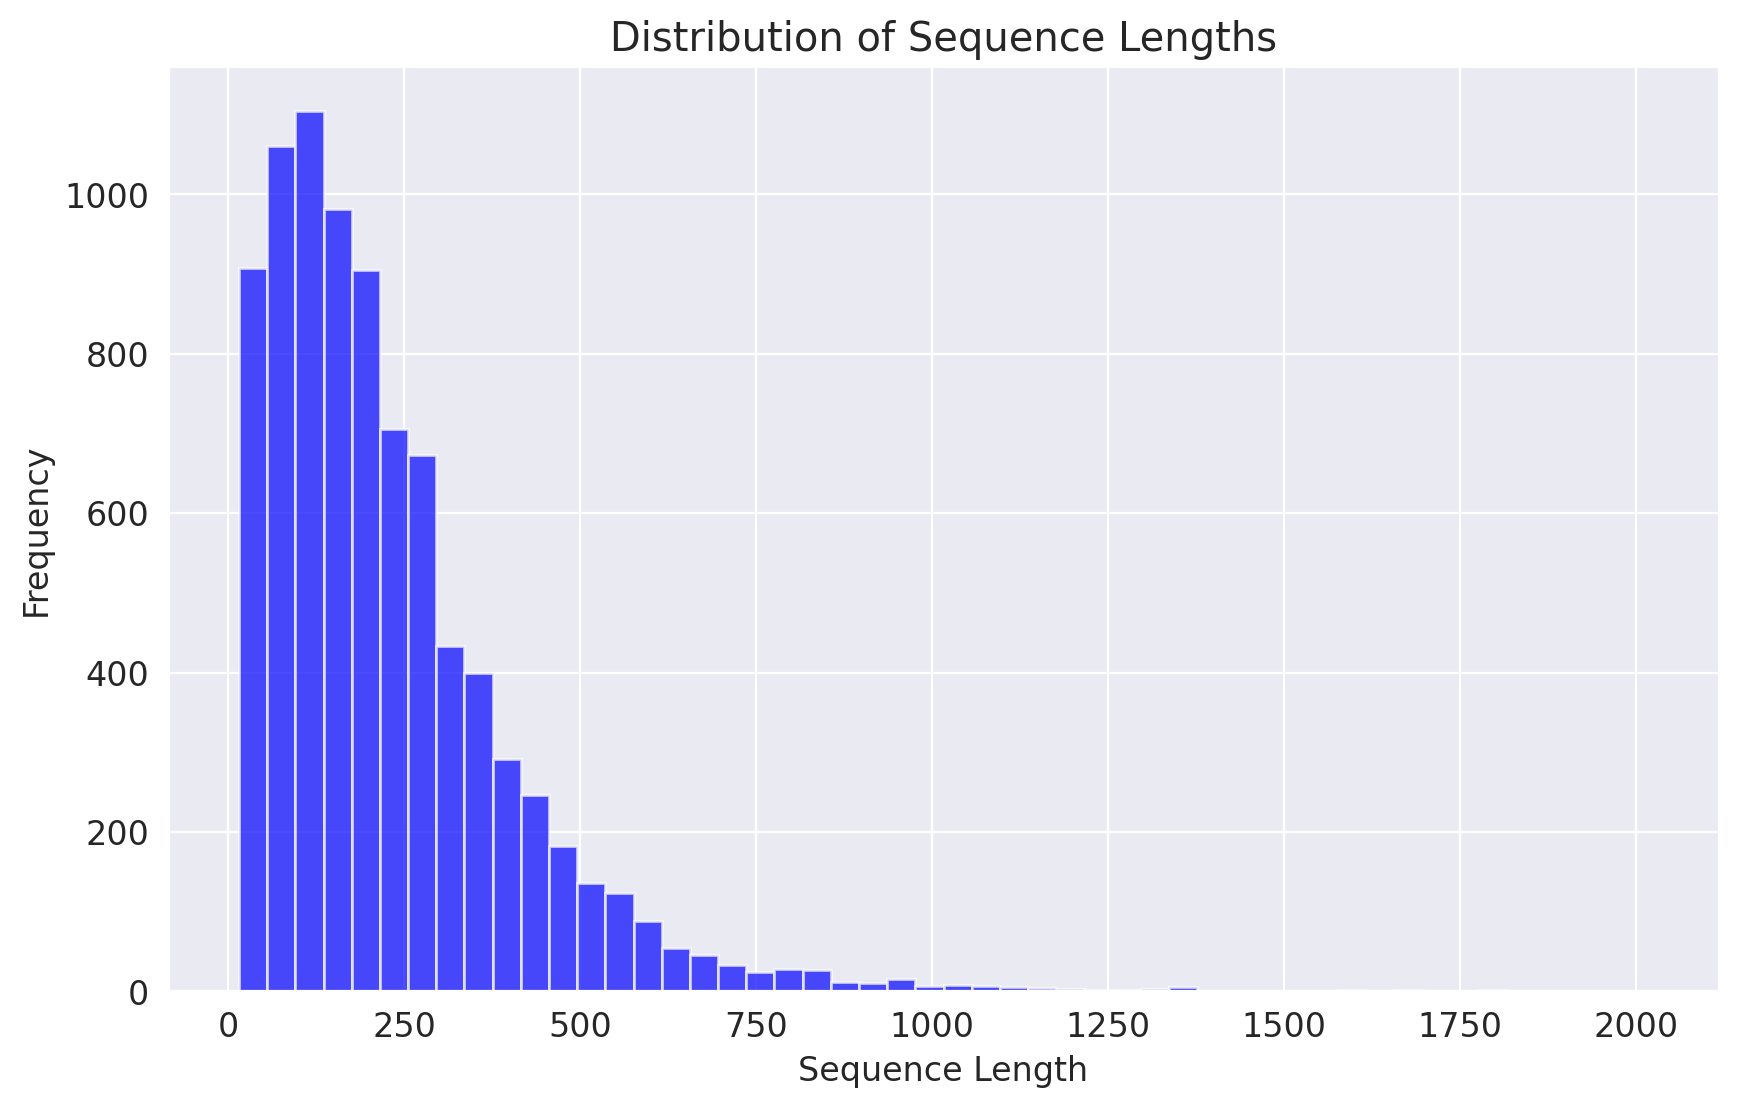

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_sequence_length(example):
    return {'length': len(example['input_ids'])}

lengths_dataset = tokenized_datasets["test"].map(get_sequence_length, num_proc=8, remove_columns=tokenized_datasets["test"].column_names)

lengths = pd.Series(lengths_dataset['length'])

print("Descriptive statistics for sequence lengths:")
print(lengths.describe())

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

обрежем все до 360, все равно весь датасет не поместиться в обучение из-за того, что полную эпоху очень долго обучать

In [99]:
NUM_PROC = 8
def tokenize_function(examples):
    return tokenizer(examples['chosen'], padding="max_length", truncation=True, max_length=360)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=dataset["train"].column_names, num_proc=NUM_PROC)

Map (num_proc=8):   0%|          | 0/160800 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/8552 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/8552 [00:00<?, ? examples/s]

Descriptive statistics for sequence lengths:
count    8552.0
mean      360.0
std         0.0
min       360.0
25%       360.0
50%       360.0
75%       360.0
max       360.0
dtype: float64


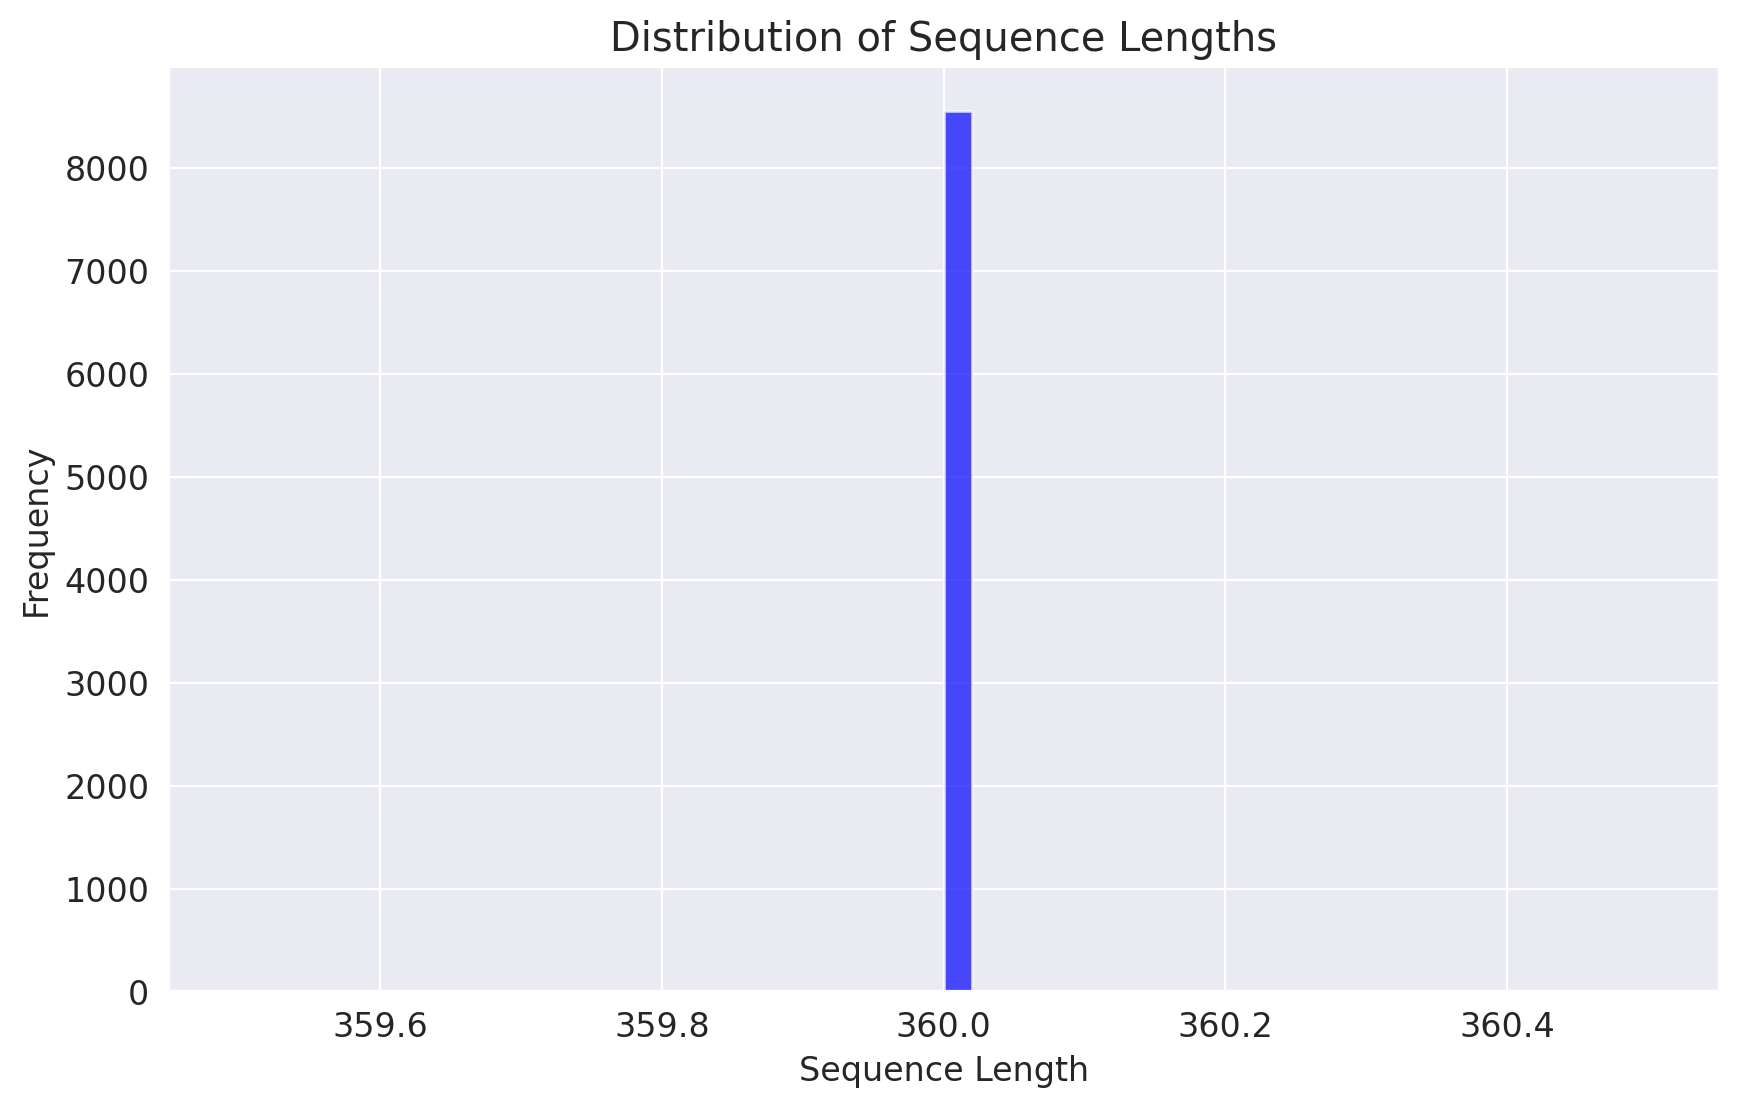

In [100]:
lengths_dataset = tokenized_datasets["test"].map(get_sequence_length, num_proc=8, remove_columns=tokenized_datasets["test"].column_names)

lengths = pd.Series(lengths_dataset['length'])

print("Descriptive statistics for sequence lengths:")
print(lengths.describe())

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [31]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

In [32]:
tokenized_datasets["test"]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 8552
})

In [33]:
train_dataset = tokenized_datasets["train"].select(range(50_000))
eval_dataset = tokenized_datasets["test"].select(range(5_000))

In [34]:
from transformers import (
    TrainingArguments,
    Trainer,
    PreTrainedTokenizerBase,
    DataCollatorForLanguageModeling,
)

# --- Directory & Logging Constants ---
OUTPUT_DIR = "./lora"
RUN_NAME = "lora-v1.0"
LOGGING_DIR = f"{OUTPUT_DIR}/logs/{RUN_NAME}"

# --- Core Training Hyperparameters ---
LEARNING_RATE = 2e-5
PER_DEVICE_TRAIN_BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = 2  # effective batch size = 8
NUM_TRAIN_EPOCHS = 1
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# --- Evaluation, Saving, & Logging ---
EVAL_STEPS = 50
SAVE_STEPS = 50
LOGGING_STEPS = 2
SAVE_TOTAL_LIMIT = 1
METRIC_FOR_BEST_MODEL = "eval_loss"
LOAD_BEST_MODEL_AT_END = True
GREATER_IS_BETTER = False

# --- Strategy ---
LOGGING_STRATEGY = "steps"
EVALUATION_STRATEGY = "steps"
SAVE_STRATEGY = "steps"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    run_name=RUN_NAME,
    report_to="tensorboard",

    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
    logging_dir=LOGGING_DIR,
    logging_strategy=LOGGING_STRATEGY,
    logging_steps=LOGGING_STEPS,
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_total_limit=SAVE_TOTAL_LIMIT,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    greater_is_better=GREATER_IS_BETTER,

    fp16=True,
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    data_collator=data_collator,
)

/home/user/Desktop/SSL/ssl-env/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer.train()

Step,Training Loss,Validation Loss
50,2.241500,2.130285
100,2.133700,2.014339
150,1.803200,1.937413
200,1.839700,1.916346
250,2.032000,1.905780


KeyboardInterrupt: 

вот запуск из терминала, который я до этого сам запускал (на том запуске я не обрезал датасет)

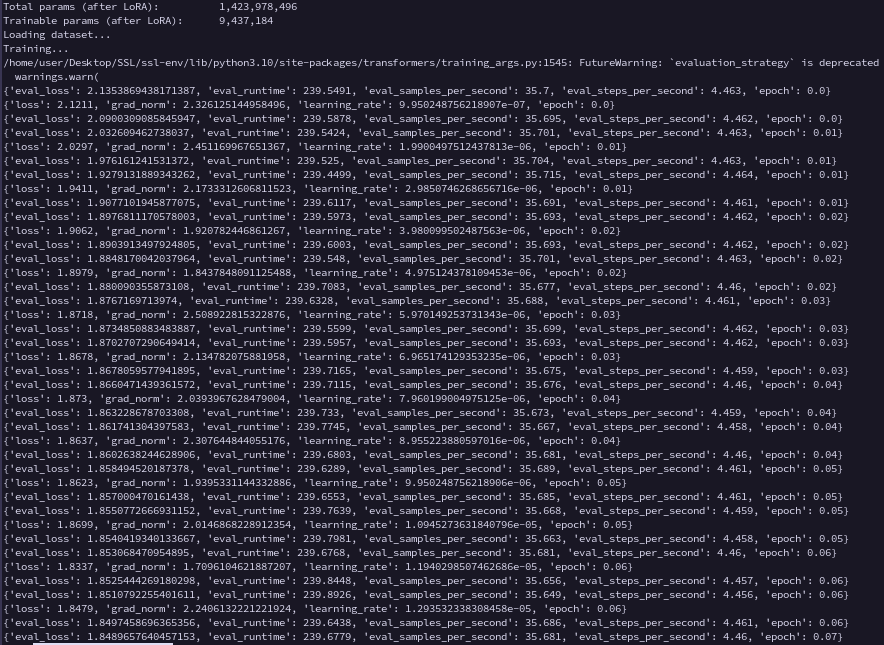

Вот скрин из тензорборда, в доказательство, что все учится (можно его получить из логов в ./lora)
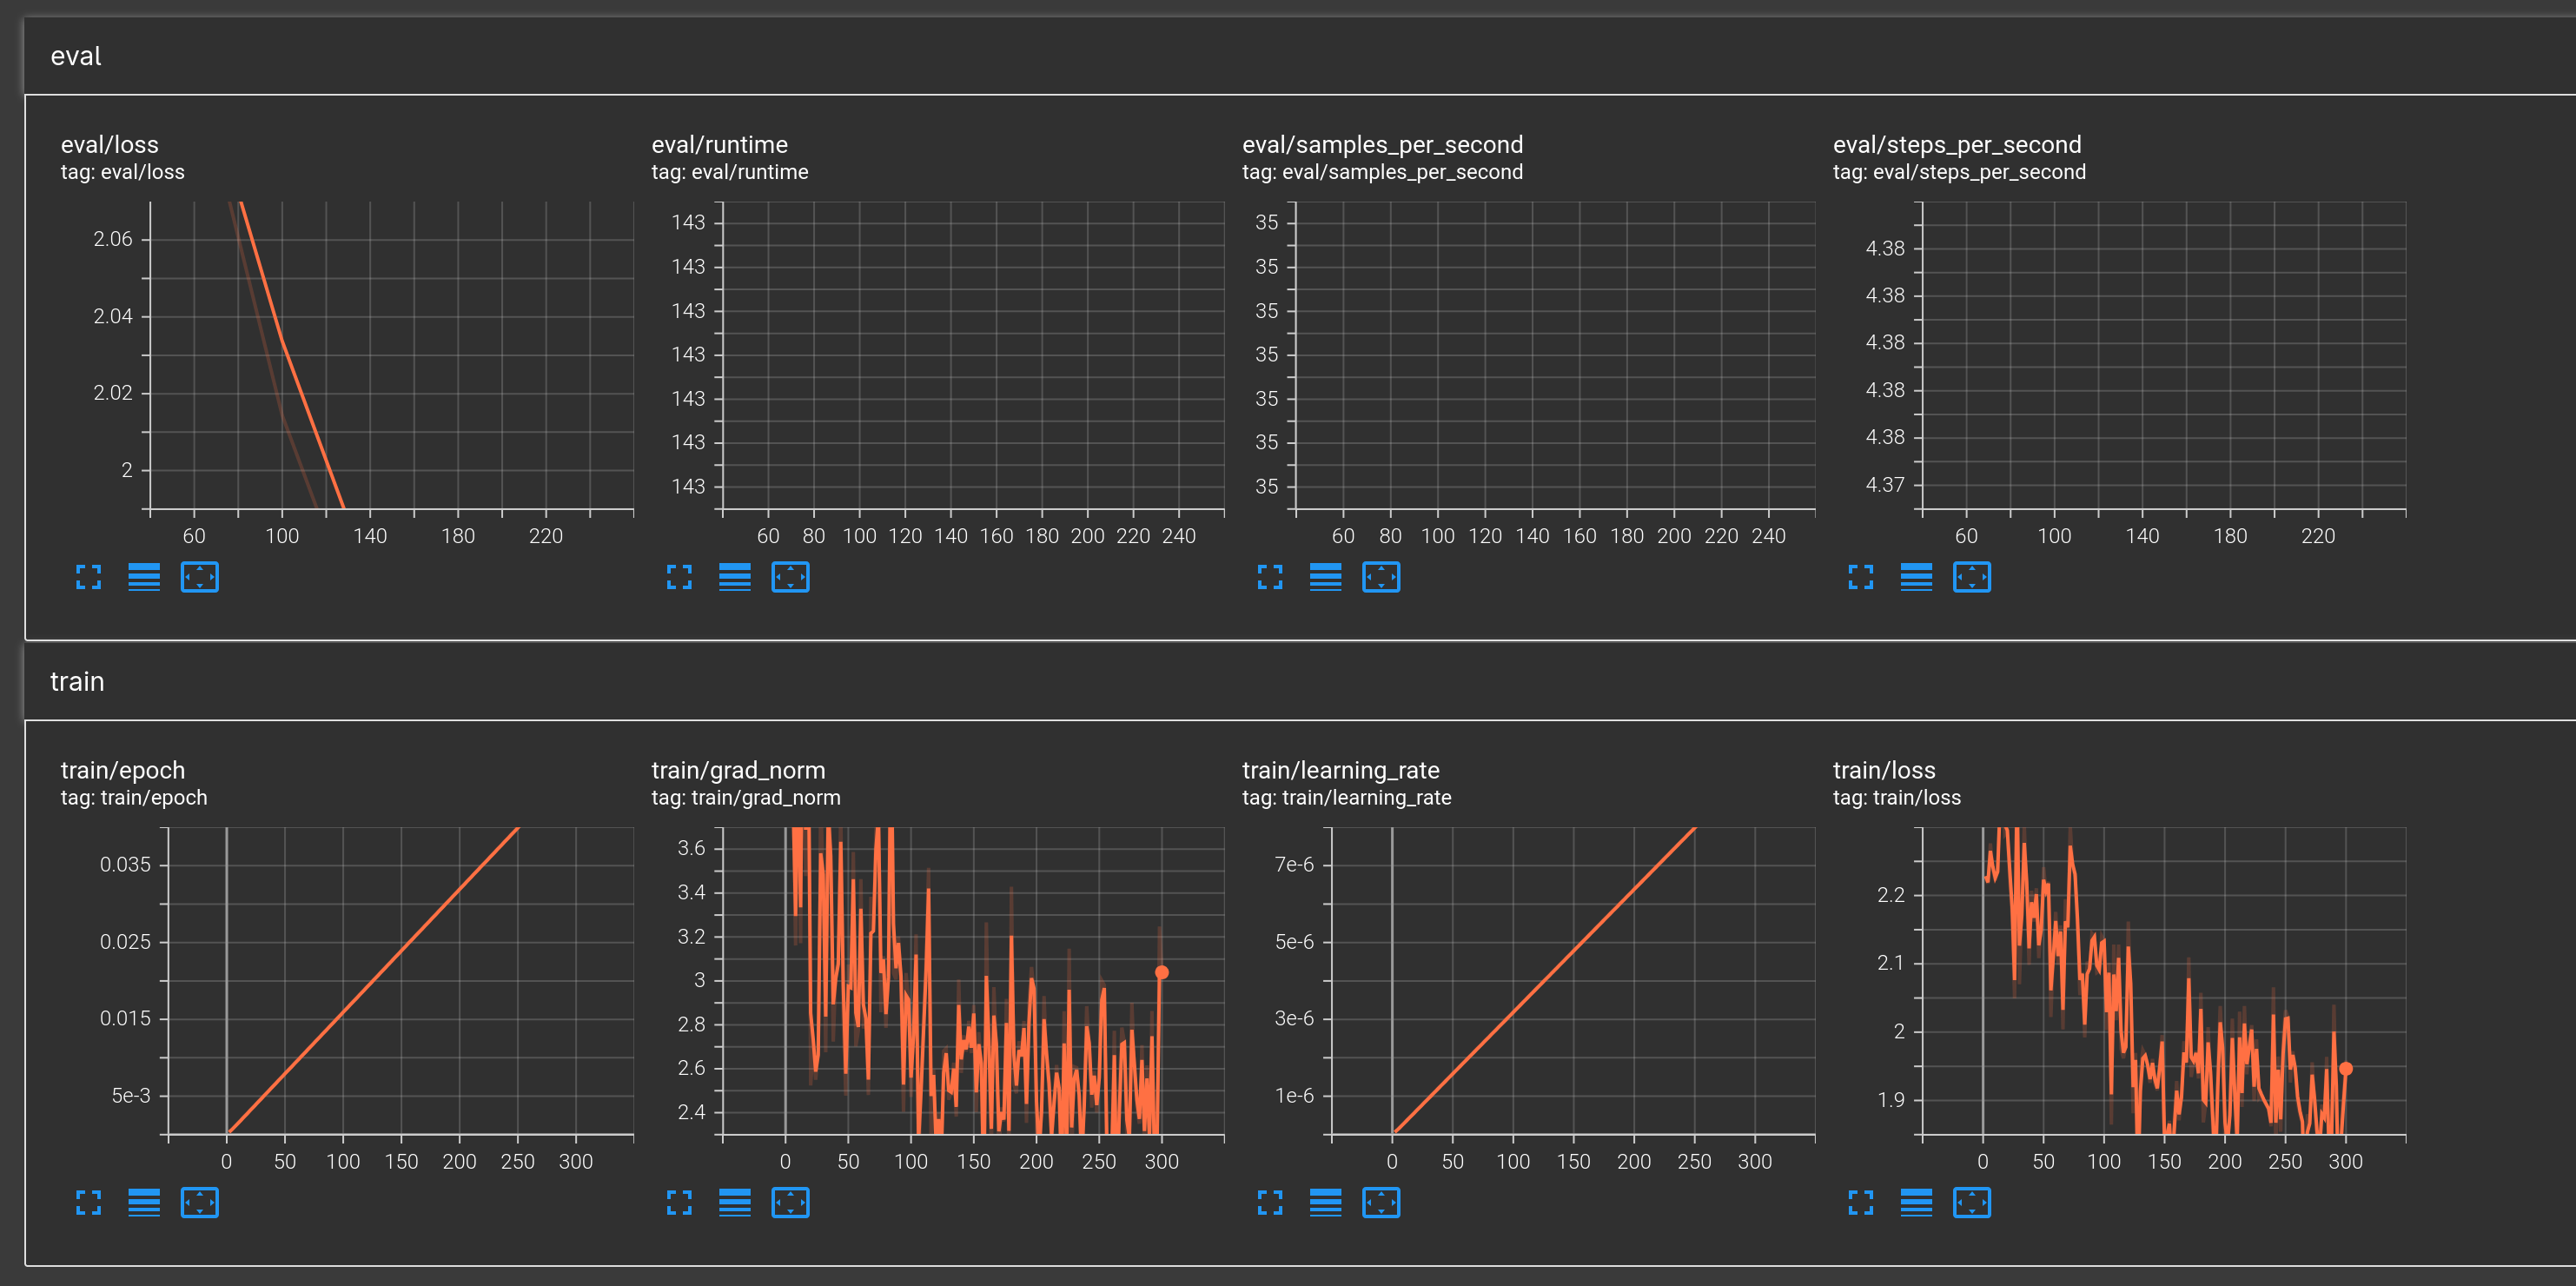

### Supervised Fine-tuning

__Задание 2 (3 балла).__ Разбейте все примеры с "хорошими" ответами на запросы (все что идет до последнего "Assistant:") и ответы (все, начиная с последнего "Assistant:"). Дообучите модель [`pythia-1.4b`](https://huggingface.co/EleutherAI/pythia-1.4b) генерировать правильные ответы с помощью вашей LoRA. Одной эпохи вполне должно хватить для сходимости. Проверьте на нескольких случайных тестовых примерах, что модель ведет себя так, как надо.

In [72]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch import nn
from src.lora import LoRALayer

MODEL = 'EleutherAI/pythia-1.4b'
RANK = 32

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

for param in model.parameters():
    param.requires_grad = False

modules_to_replace = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and (name.endswith('dense') or name.endswith('query_key_value')):
        modules_to_replace.append(name)

for name in modules_to_replace:
    parent_name = ".".join(name.split('.')[:-1])
    child_name = name.split('.')[-1]
    parent_module = model.get_submodule(parent_name)
    target_module = getattr(parent_module, child_name)

    lora_layer = LoRALayer(target_module, RANK)
    setattr(parent_module, child_name, lora_layer)
    print(f"Replaced {name} with LoRALayer")

Replaced gpt_neox.layers.0.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.0.attention.dense with LoRALayer
Replaced gpt_neox.layers.1.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.1.attention.dense with LoRALayer
Replaced gpt_neox.layers.2.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.2.attention.dense with LoRALayer
Replaced gpt_neox.layers.3.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.3.attention.dense with LoRALayer
Replaced gpt_neox.layers.4.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.4.attention.dense with LoRALayer
Replaced gpt_neox.layers.5.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.5.attention.dense with LoRALayer
Replaced gpt_neox.layers.6.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.6.attention.dense with LoRALayer
Replaced gpt_neox.layers.7.attention.query_key_value with LoRALayer
Replaced gpt_neox.layers.7.attention.dense with Lo

In [110]:
MAX_LEN = 360
# Я попросил у Gemini 2.5 написать эту функцию, так как не хотелось возиться с форматом
def format_for_sft(example):
    last_assistant_idx = example['chosen'].rfind("Assistant:")
    if last_assistant_idx == -1:
        # If not found, skip (or handle empty prompt/response)
        prompt = ''
        response = ''
    else:
        prompt = example['chosen'][:last_assistant_idx].strip()
        response = example['chosen'][last_assistant_idx:].replace("Assistant:", "", 1).strip()

    prompt = tokenizer(prompt, padding="max_length", truncation=True, max_length=MAX_LEN)['input_ids']
    response = tokenizer(response, padding="max_length", truncation=True, max_length=MAX_LEN)['input_ids']

    prompt_len = len(prompt)
    input_ids = prompt + response + [tokenizer.eos_token_id]

    # create labels, masking out the prompt
    # the model should only learn to predict the response
    labels = ([-100] * prompt_len) + response + [tokenizer.eos_token_id]

    # handle truncation if the combined length is too long
    if len(input_ids) > MAX_LEN:
        input_ids = input_ids[:MAX_LEN-1] + [tokenizer.eos_token_id]
        labels = labels[:MAX_LEN-1] + [tokenizer.eos_token_id]

    attention_mask = [1] * len(input_ids)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

In [111]:

trainset = dataset['train'].map(format_for_sft, num_proc=NUM_PROC)
evalset = dataset['test'].map(format_for_sft, num_proc=NUM_PROC)

Map (num_proc=8):   0%|          | 0/160800 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/8552 [00:00<?, ? examples/s]

In [112]:
trainset

Dataset({
    features: ['chosen', 'rejected', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 160800
})

In [68]:
# print(dataset["test"][0]["chosen"])

In [64]:
# print("\n\nACCEPTED:", dataset["train"][0]["chosen"], "\n\n" +"="*100+ "\n\nREJECTED:", dataset["train"][0]["rejected"])

In [121]:
train_dataset =trainset.select(range(100_000))
eval_dataset = evalset.select(range(3_000))

import torch
torch.set_float32_matmul_precision('medium')

# --- Directory & Logging Constants ---
OUTPUT_DIR = "./sft"
RUN_NAME = "sft-v1.0"
LOGGING_DIR = f"{OUTPUT_DIR}/logs/{RUN_NAME}"

# --- Core Training Hyperparameters ---
LEARNING_RATE = 2e-5
PER_DEVICE_TRAIN_BATCH_SIZE = 5
PER_DEVICE_EVAL_BATCH_SIZE = 15
GRADIENT_ACCUMULATION_STEPS = 2  # effective batch size = 10
NUM_TRAIN_EPOCHS = 1
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# --- Evaluation, Saving, & Logging ---
EVAL_STEPS = 500
SAVE_STEPS = 1000
LOGGING_STEPS = 2
SAVE_TOTAL_LIMIT = 1
METRIC_FOR_BEST_MODEL = "eval_loss"
LOAD_BEST_MODEL_AT_END = True
GREATER_IS_BETTER = False

# --- Strategy ---
LOGGING_STRATEGY = "steps"
EVALUATION_STRATEGY = "steps"
SAVE_STRATEGY = "steps"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    # --- LR Scheduler ---
    lr_scheduler_type='reduce_lr_on_plateau',
    lr_scheduler_kwargs={
        "mode": "min",
        "factor": 0.5,
        "patience": 1,
    },

    run_name=RUN_NAME,
    report_to="tensorboard",

    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
    logging_dir=LOGGING_DIR,
    logging_strategy=LOGGING_STRATEGY,
    logging_steps=LOGGING_STEPS,
    eval_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_total_limit=SAVE_TOTAL_LIMIT,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    greater_is_better=GREATER_IS_BETTER,
    eval_on_start=True,

    fp16=True,
    torch_compile=True,
    torch_compile_backend="inductor",
    torch_compile_mode="default",
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [122]:
trainer.train()

Step,Training Loss,Validation Loss
0,No log,1.970693
500,1.904500,1.936500
1000,1.959200,1.920334
1500,1.828500,1.909619
2000,1.815900,1.903155
2500,1.894800,1.895026
3000,2.122700,1.890524
3500,1.777200,1.885633
4000,1.898100,1.881199
4500,1.851700,1.877732


TrainOutput(global_step=10000, training_loss=1.8793743035078048, metrics={'train_runtime': 5674.0022, 'train_samples_per_second': 17.624, 'train_steps_per_second': 1.762, 'total_flos': 2.85337976832e+17, 'train_loss': 1.8793743035078048, 'epoch': 1.0})

Во время обучения понял, что надо было просто выкинуть длинные примеры, а не обрезать их, так как все равно обрезаю до 100к выборку, чтобы полную эпоху проучить. 
Валидацию надо было вообще не резать по длине, лучше примеров меньше взять, чтобы не было байеса в сторону маленьких длин. Если останется время, перезапущу эксп, сравнить валидацию во время обучения не получится, но после обучения сравню на не порезанной валидации.
чувствительность шедулера тоже надо понизить, так как он не успел шагнуть достаточное количество шагов для снижения lr, возможно стоит взять вместо ReduceOnPlateu CosineAnealing. Я выбрал текущий шедулер, потому, что думал, что есть вероятность остановить досрочно обучение, если обучение сойдется раньше, но этого не произошло.
LR вроде выбран нормально. Я рассматривал только взять его больше до начала обучения, но в этом случае стоило бы увеличить вармап, так как даже после вармапа градиенты по виду довольно сильно шумели. Не знаю, насколько норм, что у меня так шумят градиенты, возможно стоило поставить больше Gradient Accumulation Step.
Еще прикольно было бы включить другие штуки в логгинг типа примеров на которых модель ошибается и утилизации GPU и кол-во памяти GPU.

In [130]:
SAVE_PATH = "sft.pt"

torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
trainset.save_to_disk('trainset')
evalset.save_to_disk('evalset')

### Direct Preference Optimization

__Задание 3 (3 балла).__ Реализуйте DPO согласно [статье](https://arxiv.org/pdf/2305.18290) и дообучите SFT модель с предыдущего шага. Одной эпохи так же должно хватить, но можно обучать и дольше. Убедитесь, что модель начинает отдавать предпочтение хорошим ответам. Проведите анализ. Стали ли ответы лучше, чем у SFT модели? Всегда ли модель отвечает хорошо или иногда плохо? Насколько легко модель ломается при изменении промптов?

In [ ]:
from src.main_dpo import *

/home/user/Desktop/SSL/ssl-env/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
INFO:src.main_dpo:Loading tokenizer...
INFO:src.main_dpo:Loading datasets...
INFO:src.main_dpo:Dataser:
DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 160800
    })
    test: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 8552
    })
})


Filter (num_proc=12):   0%|          | 0/160800 [00:00<?, ? examples/s]